In [174]:
# import findspark
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, DecimalType
from pyspark.sql import functions as f
import warnings 
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import getpass

# findspark.init()
spark = SparkSession.builder.getOrCreate()

In [2]:
spark

In [3]:
# Conectando ao banco de dados e lendo a tabela

driver = 'com.microsoft.sqlserver.jdbc.SQLServerDriver'
username = 'sa'
password = getpass.getpass('password: ')
db = 'Olist'
server = 'DESKTOP-8RSP3AB'
port = '1433'

df = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_order_payments]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

In [4]:
df.limit(5).show()

+--------------------+------------------+------------+--------------------+-------------+
|            order_id|payment_sequential|payment_type|payment_installments|payment_value|
+--------------------+------------------+------------+--------------------+-------------+
|b81ef226f3fe1789b...|                 1| credit_card|                   8|        99.33|
|a9810da82917af2d9...|                 1| credit_card|                   1|        24.39|
|25e8ea4e93396b6fa...|                 1| credit_card|                   1|        65.71|
|ba78997921bbcdc13...|                 1| credit_card|                   8|       107.78|
|42fdf880ba16b47b5...|                 1| credit_card|                   2|       128.45|
+--------------------+------------------+------------+--------------------+-------------+



In [8]:
# verificando as colunas e os tipos
df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- payment_sequential: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: string (nullable = true)
 |-- payment_value: string (nullable = true)



### Entendendo a base

A base possui 103.886 linhas e 5 colunas, sendo elas:

- **order_id**: Identificador único das vendas
- **payment_sequential**: Quantidade de métodos de pagamentos utilizados no pedido
- **payment_type**: Método de pagamento utilizado
- **payment_installments**: Número de parcelas
- **payment_value**: Valor do pagamento

In [340]:
# Quantidade de linhas na base

df.count()

103886

In [46]:
# Quantidade de linhas com valores nulos por coluna

df.select(
    [f.count( f.when( f.isnull( column ), 1 ) ).alias( column ) for column in df.columns]
).show()

+--------+------------------+------------+--------------------+-------------+
|order_id|payment_sequential|payment_type|payment_installments|payment_value|
+--------+------------------+------------+--------------------+-------------+
|       0|                 0|           0|                   0|            0|
+--------+------------------+------------+--------------------+-------------+



In [6]:
# verificando se existem valores (float) na coluna 'payment_value' que possuem vírgula
 
df.withColumn('payment_value', f.regexp_extract('payment_value', r'\d,\d', 0)).filter(" payment_value != '' ").show()

+--------+------------------+------------+--------------------+-------------+
|order_id|payment_sequential|payment_type|payment_installments|payment_value|
+--------+------------------+------------+--------------------+-------------+
+--------+------------------+------------+--------------------+-------------+



In [7]:
# transformando a variável em double 

df = df.withColumn('payment_value',df.payment_value.cast(DoubleType()))
df.withColumn('payment_value',df.payment_value.cast(DoubleType())).printSchema()

root
 |-- order_id: string (nullable = true)
 |-- payment_sequential: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: string (nullable = true)
 |-- payment_value: double (nullable = true)



In [61]:
# Tipos de pagamento

df \
    .select(df.payment_type)\
    .distinct()\
    .show()

+------------+
|payment_type|
+------------+
|      boleto|
| not_defined|
| credit_card|
|     voucher|
|  debit_card|
+------------+



In [184]:
# Quantidade de pedidos e valor por cada categoria de método de pagamento 

df_payment_type = df\
    .select('payment_type','order_id','payment_value')\
    .groupBy('payment_type')\
    .agg(
        f.count('order_id').alias('qtd_pedidos'),
        f.sum('payment_value').cast(DecimalType(18, 2)).alias('vl_total')
    )\
    .orderBy('vl_total', ascending = False)\
    .toPandas()\
    .set_index('payment_type')

df_payment_type

,qtd_pedidos,vl_total
payment_type,,
credit_card,76795,12542084.19
boleto,19784,2869361.27
voucher,5775,379436.87
debit_card,1529,217989.79
not_defined,3,0.00


- 3 pedidos não possuem método de pagamento definido e possuem juntos um valor de 0. 

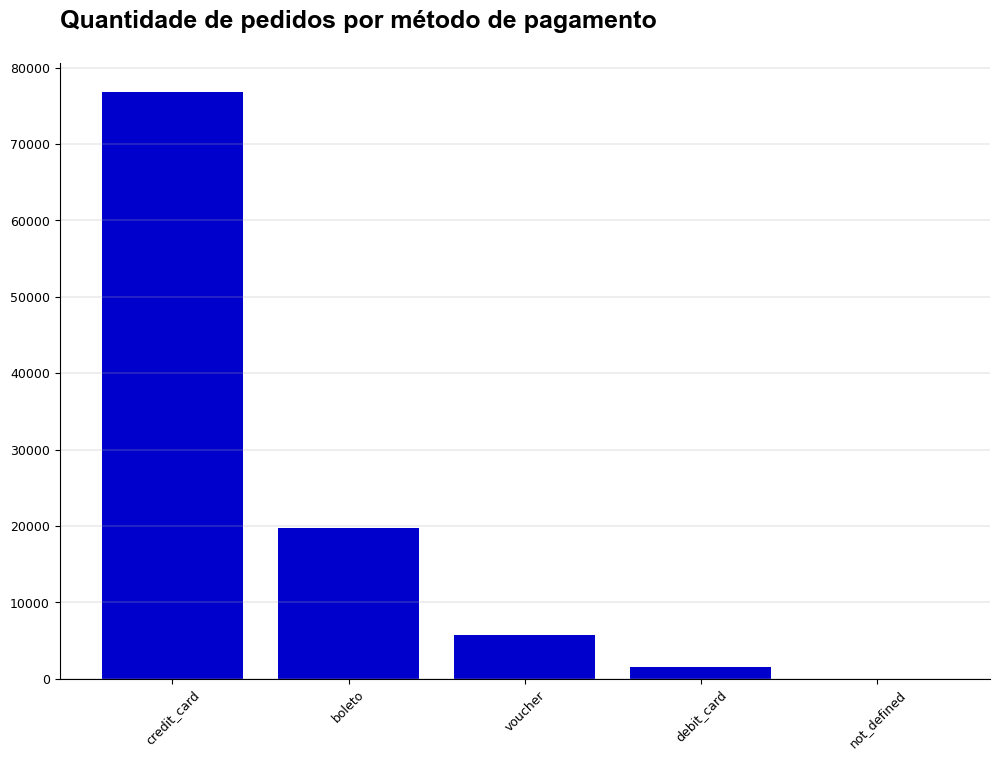

In [205]:
fig = plt.figure(figsize = (12,8))


plt.title('Quantidade de pedidos por método de pagamento \n', fontsize = 18, fontweight = 'bold', fontfamily = 'arial', loc = 'left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().xaxis.set_tick_params(labelsize = 9, rotation = 45)
plt.gca().yaxis.set_tick_params(labelsize = 9)
plt.grid(True, axis = 'y', linewidth = .3)

plt.bar(x = df_payment_type.index, height = df_payment_type.qtd_pedidos, color = 'mediumblue');

- Cartão de crédito forma maioria em volumetria de pedidos.

In [214]:
# Estatísticas básicas para o valor dos pedidos

df.select('payment_value').toPandas().describe().round(2)

,payment_value
count,103886.00
mean,154.10
std,217.49
min,0.00
25%,56.79
50%,100.00
75%,171.84
max,13664.08


- O valor médio de um pedido é de R$ 154.10, com um desvio padrão de R$217.49, mostrando uma variação relativamente alta entre os valores dos pedidos. Isso fica mais evidente quando olhamos para a diferença entre o quantil 75 (ou terceiro quartil) e o valor máximo.

In [162]:
# Filtrando maiores valores em cada meio de pagamento

for type in list(df.select('payment_type').distinct().toPandas()['payment_type']):
    print(f'maior valor pagamento em >{type}< : {df.where(df.payment_type == type).select(f.max(df.payment_value)).collect()[0][0]}')

maior valor pagamento em >boleto< : 7274.88
maior valor pagamento em >not_defined< : 0.0
maior valor pagamento em >credit_card< : 13664.08
maior valor pagamento em >voucher< : 3184.34
maior valor pagamento em >debit_card< : 4445.5


# Produtos mais vendidos e valor por produtos (tabela de produtos)

In [224]:
# tabela de produtos
df_prod = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_products]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

# tabela de vendas
df_ord = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_orders]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

# tabela de items
df_items = spark.read \
  .format('jdbc') \
  .option("url", f"jdbc:sqlserver://{server}:{port};databaseName={db};trustServerCertificate=true") \
  .option("dbtable", "[dbo].[olist_order_items]") \
  .option('driver', driver) \
  .option("user", username) \
  .option("password", password) \
  .load()

In [219]:
df_prod.show(5)

+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|          product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|1e9e8ef04dbcff454...|           perfumaria|                 40|                       287|                 1|             225|               16|               10|              14|
|3aa071139cb16b67c...|                artes|                 44|                       276|                 1|            1000|               30|               18|              20|
|96bd76ec8810374ed...|        esporte_lazer|                 46|                       250|    

In [220]:
df_ord.show(5)

+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|9ef432eb625129730...|   delivered|        02/10/2017 10:56| 02/10/2017 11:07|            04/10/2017 19:55|             10/10/2017 21:25|             18/10/2017 00:00|
|53cdb2fc8bc7dce0b...|b0830fb4747a6c6d2...|   delivered|        24/07/2018 20:41| 26/07/2018 03:24|            26/07/2018 14:31|             07/08/2018 15:27|             13/08/2018 00:00|
|47770eb9100c2d0c4...|41ce2a54c0b03bf34...|   delivered

In [225]:
df_items.show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date| price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|   19/09/2017 09:45| 58.90|        13.29|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|   03/05/2017 11:05|239.90|        19.93|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|   18/01/2018 14:48|199.00|        17.87|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|   15/08/2018 10:10| 12.99|        12.79|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|   13/02/2017 13:57|199.90|        18.14|
+--------------------+-------------+----

In [238]:
# Montando tabela

df_join = df\
    .join(df_ord, on = 'order_id', how = 'inner')\
    .select('*')\
    .join(df_items, on = 'order_id', how = 'inner')\
    .select('*')\
    .join(df_prod, on = 'product_id', how = 'inner')\
    .select(
        df.order_id, 
        df_ord.order_status, 
        df_ord.order_approved_at, 
        df.payment_type, 
        df.payment_value, 
        df_items.product_id, 
        df_items.order_item_id, 
        df_items.price, 
        df_items.freight_value,
        df_prod.product_category_name
    )

df_join.show(5, False)

+--------------------------------+------------+-----------------+------------+-------------+--------------------------------+-------------+------+-------------+---------------------+
|order_id                        |order_status|order_approved_at|payment_type|payment_value|product_id                      |order_item_id|price |freight_value|product_category_name|
+--------------------------------+------------+-----------------+------------+-------------+--------------------------------+-------------+------+-------------+---------------------+
|00018f77f2f0320c557190d7a144bdd3|delivered   |26/04/2017 11:05 |credit_card |259.83       |e5f2d52b802189ee658865ca93d83a8f|1            |239.90|19.93        |pet_shop             |
|00054e8431b9d7675808bcb819fb4a32|delivered   |10/12/2017 12:10 |credit_card |31.75        |8d4f2bb7e93e6710a28f34fa83ee7d28|1            |19.90 |11.85        |telefonia            |
|000aed2e25dbad2f9ddb70584c5a2ded|delivered   |11/05/2018 20:57 |credit_card |152.77 

In [246]:
# Categorias de produtos

df_join.select('product_category_name').distinct().show()

+---------------------+
|product_category_name|
+---------------------+
|                  pcs|
|                bebes|
|                artes|
|            cine_foto|
|     moveis_decoracao|
|             pc_gamer|
| construcao_ferram...|
| tablets_impressao...|
|    artigos_de_festas|
| fashion_roupa_mas...|
|     artigos_de_natal|
|           la_cuisine|
|               flores|
|      livros_tecnicos|
|       telefonia_fixa|
| construcao_ferram...|
|           cool_stuff|
|     eletrodomesticos|
|    livros_importados|
|             pet_shop|
+---------------------+
only showing top 20 rows



In [308]:
# Verificando se existem valores em branco na coluna de categoria do produto:

df_join.createOrReplaceTempView('viewDF')

spark.sql(
'''
SELECT 
    COUNT(product_category_name) AS qtd_prod_sem_cat
FROM viewDF
WHERE product_category_name = ''
'''
).show()

+----------------+
|qtd_prod_sem_cat|
+----------------+
|            1698|
+----------------+



In [309]:
spark.sql(
'''
SELECT
    COUNT(product_category_name) AS qtd_prod_sem_cat
FROM viewDF
WHERE product_category_name = ' '
'''
).show()

+----------------+
|qtd_prod_sem_cat|
+----------------+
|            1698|
+----------------+



In [302]:
df_join.where("product_category_name = ''").show(5)

+--------------------+------------+-----------------+------------+-------------+--------------------+-------------+------+-------------+---------------------+
|            order_id|order_status|order_approved_at|payment_type|payment_value|          product_id|order_item_id| price|freight_value|product_category_name|
+--------------------+------------+-----------------+------------+-------------+--------------------+-------------+------+-------------+---------------------+
|00ed64bc080d87b4a...|   delivered| 31/05/2017 18:22| credit_card|        61.01|fbb1cfc2810efabf3...|            1| 44.90|        16.11|                     |
|03ba96e3cd1a918f1...|   delivered| 29/11/2017 21:56| credit_card|        57.55|4914f8796af2ecd35...|            1| 49.77|         7.78|                     |
|047723564a4f371af...|   delivered| 06/12/2017 19:15| credit_card|       299.39|f58e45b16a42a325c...|            1|279.99|        19.40|                     |
|05bd0df2a2f8b3719...|   delivered| 05/12/2017

- Alguns pedidos não possuem categoria do produto associada

In [303]:
# Valores nulos

df_join.select([f.count(f.when(f.isnull(col),1)).alias(col) for col in df_join.columns]).show()

+--------+------------+-----------------+------------+-------------+----------+-------------+-----+-------------+---------------------+
|order_id|order_status|order_approved_at|payment_type|payment_value|product_id|order_item_id|price|freight_value|product_category_name|
+--------+------------+-----------------+------------+-------------+----------+-------------+-----+-------------+---------------------+
|       0|           0|                0|           0|            0|         0|            0|    0|            0|                    0|
+--------+------------+-----------------+------------+-------------+----------+-------------+-----+-------------+---------------------+



In [304]:
# Valores na

df_join.select([f.count(f.when(f.isnan(col),1)).alias(col) for col in df_join.columns]).show()

+--------+------------+-----------------+------------+-------------+----------+-------------+-----+-------------+---------------------+
|order_id|order_status|order_approved_at|payment_type|payment_value|product_id|order_item_id|price|freight_value|product_category_name|
+--------+------------+-----------------+------------+-------------+----------+-------------+-----+-------------+---------------------+
|       0|           0|                0|           0|            0|         0|            0|    0|            0|                    0|
+--------+------------+-----------------+------------+-------------+----------+-------------+-----+-------------+---------------------+



In [247]:
# Quantidade de categorias

df_join.select('product_category_name').distinct().count()

74

In [336]:
# Tabela auxiliar

df_aux = df_join\
    .where("product_category_name NOT IN ('', ' ')")\
    .groupBy('product_category_name')\
    .agg(
        f.count('order_id').alias('qtd_pedidos'),
        f.sum(df_join.order_item_id * df_join.price).cast(DecimalType(10,2)).alias('vl_total_cat_produto')
    )\
    .orderBy('vl_total_cat_produto', ascending = False)

df_aux.show(5)

+---------------------+-----------+--------------------+
|product_category_name|qtd_pedidos|vl_total_cat_produto|
+---------------------+-----------+--------------------+
|         beleza_saude|       9972|          1392740.21|
|   relogios_presentes|       6201|          1308221.20|
|      cama_mesa_banho|      11823|          1293400.65|
| informatica_acess...|       8082|          1167296.08|
|        esporte_lazer|       8945|          1121122.26|
+---------------------+-----------+--------------------+
only showing top 5 rows



In [306]:
df_aux.printSchema()

root
 |-- product_category_name: string (nullable = true)
 |-- qtd_pedidos: long (nullable = false)
 |-- vl_total_cat_produto: decimal(10,2) (nullable = true)



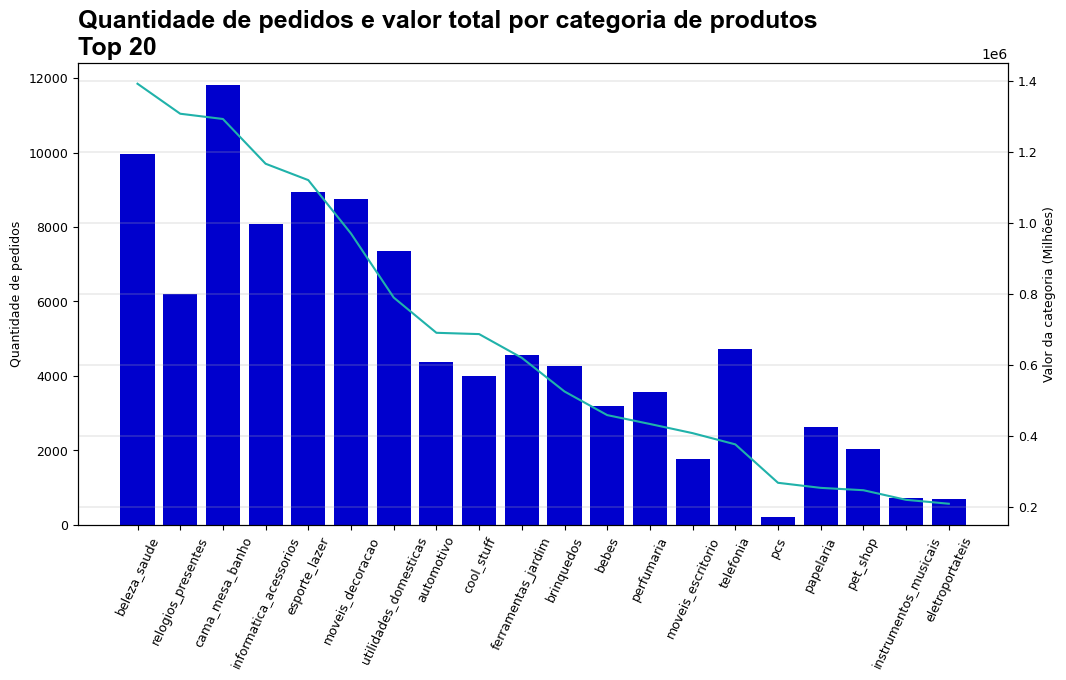

In [339]:
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()

ax.set_title('Quantidade de pedidos e valor total por categoria de produtos\nTop 20', fontfamily = 'arial', fontsize = 18, fontweight = 'bold', loc = 'left')
ax.xaxis.set_tick_params(labelsize = 9, rotation = 65)
ax.yaxis.set_tick_params(labelsize = 9)
ax.set_ylabel('Quantidade de pedidos', fontsize = 9)
ax.bar(
    x = df_aux.toPandas().set_index('product_category_name').head(20).index,
    height = df_aux.toPandas()['qtd_pedidos'].head(20),
    color = 'mediumblue'
)
ax2.yaxis.set_tick_params(labelsize = 9)
ax2.set_ylabel('Valor da categoria (Milhões)', fontsize = 9)
ax2.plot(df_aux.toPandas().set_index('product_category_name')['vl_total_cat_produto'].astype('float').head(20), color = 'lightseagreen')

plt.grid(True, which = 'both', linewidth = .3)

- Os produtos da categoria de beleza e saúde apesar de não possuirem maior volumetria de pedidos, são responsáveis pelo maior montante em valor. 
- Outra categoria que vale destacar é a de relogios e presentes, tendo cerca de metade dos pedidos da categoria com maior volumetria e sendo responsável por um montante em valor superior.